# Canny Edge Detection

**Initialization**

In [21]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
    
import lib.pgm as libpgm
import lib.conv as libconv
import lib.edge as libedge
import lib.norm as libnorm
import lib.helpers as libhelpers

**Read PGM**

In [22]:
pgm_path = '../assets/pgms/coins.ascii.pgm';
pgm = libpgm.read(pgm_path)

## Find Edges with Canny

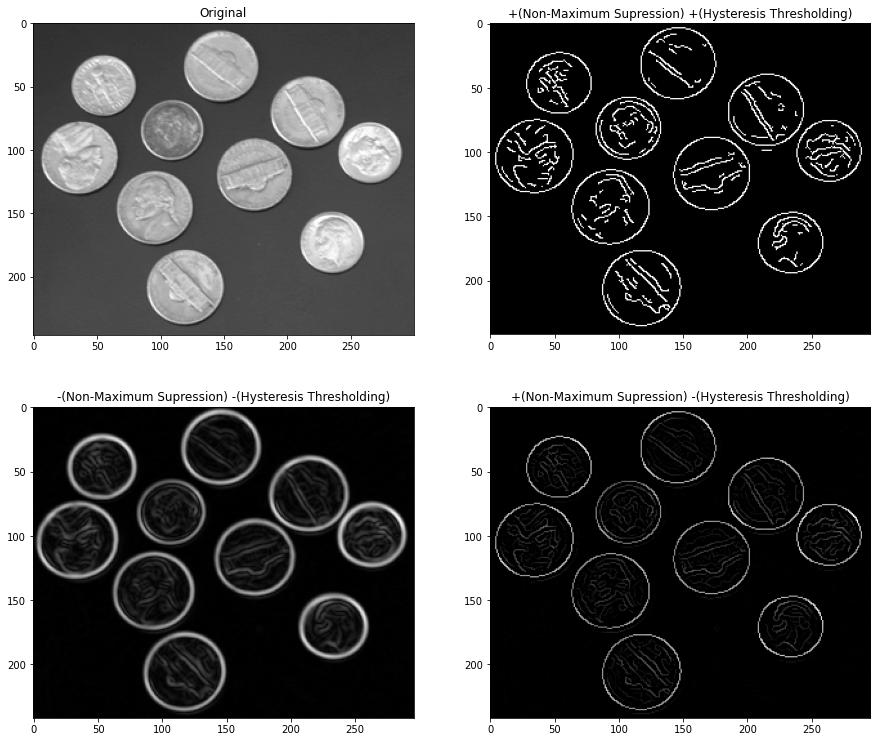

In [23]:
plt.figure(figsize=(15, 20), dpi=72)

plt.subplot(3, 2, 1)
plt.gca().set_title('Original')
libpgm.show(pgm)  

gauss_sigma = 1.4
ht_low_ratio=0.07
ht_high_ratio=0.14

# 1
image0= libhelpers.pgm_to_image(pgm)
image0 = libedge.canny(
    image0, gauss_sigma, ht_low_ratio, ht_high_ratio,
    apply_nms=True, apply_ht=True
)

plt.subplot(3, 2, 2)
plt.gca().set_title('+(Non-Maximum Supression) +(Hysteresis Thresholding)')
libhelpers.show_image(image0)

# 2
image1= libhelpers.pgm_to_image(pgm)
image1= libedge.canny(
    image1, gauss_sigma, ht_low_ratio, ht_high_ratio,
    apply_nms=False, apply_ht=False
)

plt.subplot(3, 2, 3)
plt.gca().set_title('-(Non-Maximum Supression) -(Hysteresis Thresholding)')
libhelpers.show_image(image1)

# 3
image2 = libhelpers.pgm_to_image(pgm)
image2 = libedge.canny(
    image2, gauss_sigma, ht_low_ratio, ht_high_ratio,
    apply_nms=True, apply_ht=False
)

plt.subplot(3, 2, 4)
plt.gca().set_title('+(Non-Maximum Supression) -(Hysteresis Thresholding)')
libhelpers.show_image(image2)